In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel(r"C:/Users/AS/Downloads/nickel_price_usd_monthly.xlsx")
df

,DATE,Nickel_USD_per_TNE
0,1993-01-01,5948.100098
1,1993-02-01,6050.750000
2,1993-03-01,5974.913086
3,1993-04-01,5987.500000
4,1993-05-01,5777.789551
...,...,...
383,2024-12-01,15438.656364
384,2025-01-01,15374.060870
385,2025-02-01,15287.031000
386,2025-03-01,16048.201905


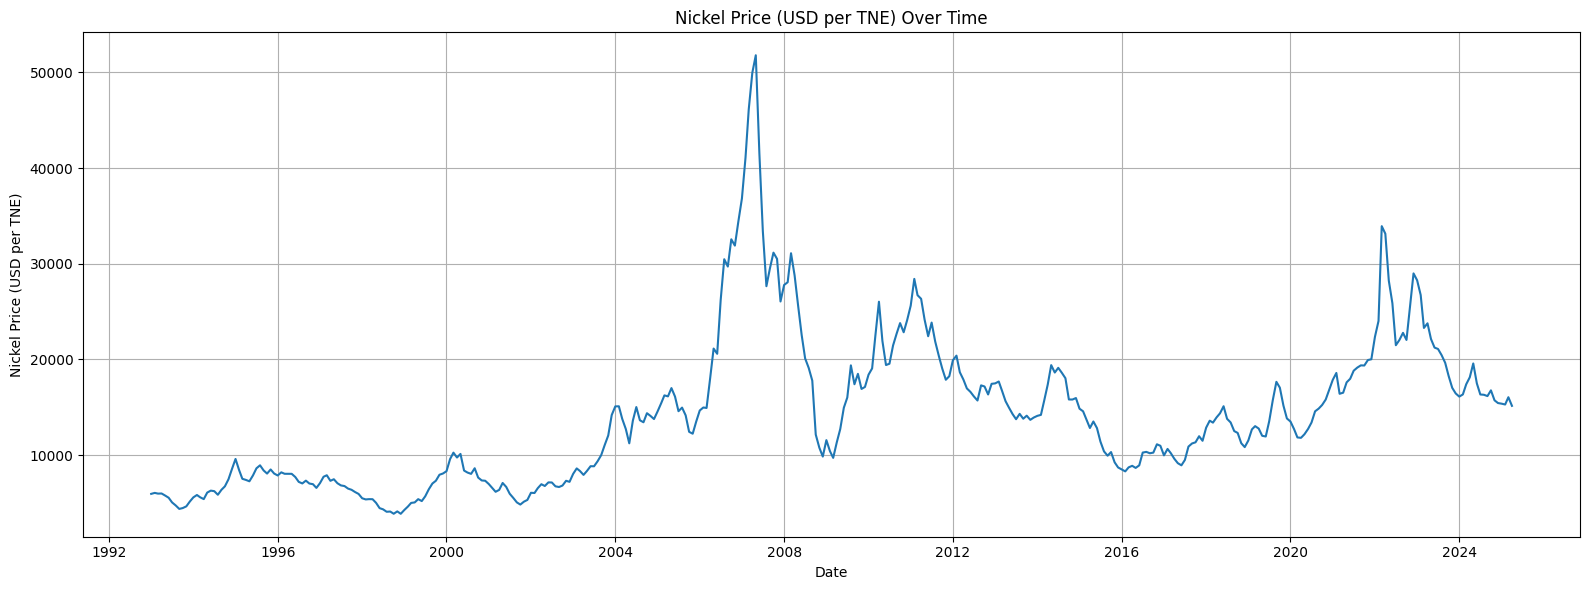

In [3]:
plt.figure(figsize=(16, 6))
plt.plot(df['DATE'], df['Nickel_USD_per_TNE'])
plt.title('Nickel Price (USD per TNE) Over Time')
plt.xlabel('Date')
plt.ylabel('Nickel Price (USD per TNE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Prepare data for time series forecasting
def create_features(df, target_col, n_lags=12):
    """Create lagged features for time series forecasting"""
    data = df.copy()
    
    # Create lagged features
    for i in range(1, n_lags + 1):
        data[f'lag_{i}'] = data[target_col].shift(i)
    
    # Create rolling statistics
    data['rolling_mean_3'] = data[target_col].rolling(window=3).mean()
    data['rolling_mean_6'] = data[target_col].rolling(window=6).mean()
    data['rolling_std_3'] = data[target_col].rolling(window=3).std()
    
    # Create time-based features
    data['month'] = data['DATE'].dt.month
    data['year'] = data['DATE'].dt.year
    data['quarter'] = data['DATE'].dt.quarter
    
    # Drop rows with NaN values
    data = data.dropna()
    
    return data

In [21]:
df_features

,DATE,Nickel_USD_per_TNE,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_3,rolling_mean_6,rolling_std_3,month,year,quarter
12,1994-01-01,5584.047852,5139.799805,4642.272949,4464.856934,4376.045410,4740.476074,5051.181641,5544.318359,5777.789551,5987.500000,5974.913086,6050.750000,5948.100098,5122.040202,4824.583171,471.138562,1,1994,1
13,1994-02-01,5830.100098,5584.047852,5139.799805,4642.272949,4464.856934,4376.045410,4740.476074,5051.181641,5544.318359,5777.789551,5987.500000,5974.913086,6050.750000,5517.982585,5006.187174,349.860098,2,1994,1
14,1994-03-01,5590.434570,5830.100098,5584.047852,5139.799805,4642.272949,4464.856934,4376.045410,4740.476074,5051.181641,5544.318359,5777.789551,5987.500000,5974.913086,5668.194173,5208.585368,140.251003,3,1994,1
15,1994-04-01,5400.263184,5590.434570,5830.100098,5584.047852,5139.799805,4642.272949,4464.856934,4376.045410,4740.476074,5051.181641,5544.318359,5777.789551,5987.500000,5606.932617,5364.486410,215.392856,4,1994,2
16,1994-05-01,6082.856934,5400.263184,5590.434570,5830.100098,5584.047852,5139.799805,4642.272949,4464.856934,4376.045410,4740.476074,5051.181641,5544.318359,5777.789551,5691.184896,5604.583740,352.273371,5,1994,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2024-12-01,15438.656364,15726.947619,16765.803478,16167.677619,16303.287727,16334.875217,17498.007500,19576.546522,18132.364091,17397.360476,16338.464286,16111.666957,16443.523810,15977.135820,16122.874671,698.051193,12,2024,4
384,2025-01-01,15374.060870,15438.656364,15726.947619,16765.803478,16167.677619,16303.287727,16334.875217,17498.007500,19576.546522,18132.364091,17397.360476,16338.464286,16111.666957,15513.221617,15962.738946,187.888923,1,2025,1
385,2025-02-01,15287.031000,15374.060870,15438.656364,15726.947619,16765.803478,16167.677619,16303.287727,16334.875217,17498.007500,19576.546522,18132.364091,17397.360476,16338.464286,15366.582744,15793.362825,76.088793,2,2025,1
386,2025-03-01,16048.201905,15287.031000,15374.060870,15438.656364,15726.947619,16765.803478,16167.677619,16303.287727,16334.875217,17498.007500,19576.546522,18132.364091,17397.360476,15569.764591,15773.450206,416.617626,3,2025,1


In [5]:
# Create features
df_features = create_features(df, 'Nickel_USD_per_TNE')

In [6]:
# Prepare X and y
feature_cols = [col for col in df_features.columns if col not in ['DATE', 'Nickel_USD_per_TNE']]
X = df_features[feature_cols]
y = df_features['Nickel_USD_per_TNE']

# Split data chronologically (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

In [8]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAPE: {mape:.2f}%")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

MAPE: 4.81%
Training samples: 300
Test samples: 76


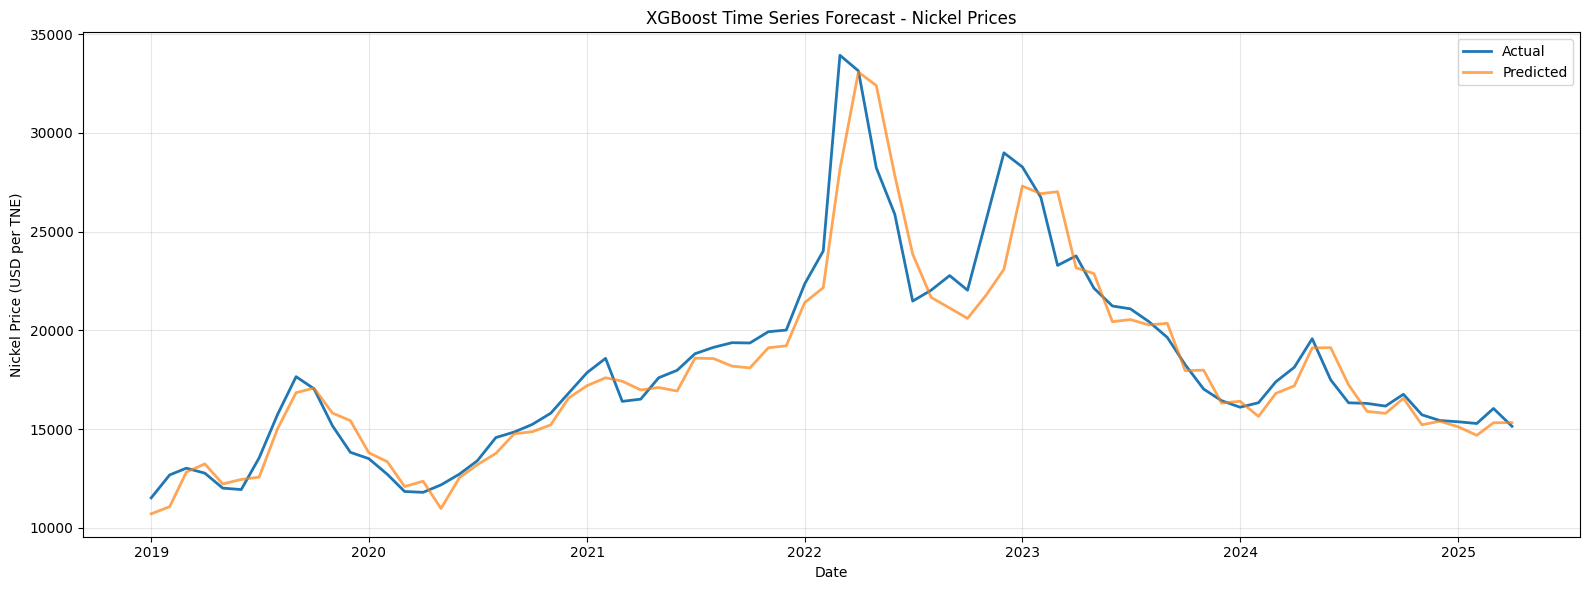

In [9]:
# Plot actual vs predicted values
plt.figure(figsize=(16, 6))
test_dates = df_features['DATE'].iloc[split_idx:]
plt.plot(test_dates, y_test.values, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.title('XGBoost Time Series Forecast - Nickel Prices')
plt.xlabel('Date')
plt.ylabel('Nickel Price (USD per TNE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
           feature  importance
12  rolling_mean_3    0.912632
0            lag_1    0.047656
15           month    0.007332
13  rolling_mean_6    0.005446
16            year    0.004150
4            lag_5    0.003918
6            lag_7    0.003101
3            lag_4    0.002611
2            lag_3    0.002475
9           lag_10    0.002043


In [11]:
# Forecast next 12 months using the trained XGBoost model
def forecast_next_months(model, last_features, n_months=12):
    """
    Forecast next n months using the trained model
    """
    forecasts = []
    current_features = last_features.copy()
    
    for i in range(n_months):
        # Make prediction
        pred = model.predict(current_features.reshape(1, -1))[0]
        forecasts.append(pred)
        
        # Update features for next prediction
        # Shift lag features
        current_features[1:12] = current_features[0:11]  # shift lag_2 to lag_12
        current_features[0] = pred  # new lag_1 is the prediction
        
        # Update rolling statistics (simplified - using last 3 predictions)
        if i >= 2:
            current_features[12] = np.mean([forecasts[i], forecasts[i-1], forecasts[i-2]])  # rolling_mean_3
            current_features[14] = np.std([forecasts[i], forecasts[i-1], forecasts[i-2]])   # rolling_std_3
        
        if i >= 5:
            current_features[13] = np.mean(forecasts[i-5:i+1])  # rolling_mean_6
        
        # Update time features
        last_date = df_features['DATE'].iloc[-1]
        next_date = last_date + pd.DateOffset(months=i+1)
        current_features[15] = next_date.month      # month
        current_features[16] = next_date.year       # year  
        current_features[17] = next_date.quarter    # quarter
    
    return forecasts

In [12]:
# Get the last row of features for forecasting
last_features = X.iloc[-1].values

# Generate 12-month forecast
future_predictions = forecast_next_months(xgb_model, last_features, 12)

# Create future dates
last_date = df_features['DATE'].iloc[-1]
future_dates = [last_date + pd.DateOffset(months=i+1) for i in range(12)]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions
})

print("12-Month Nickel Price Forecast:")
print(forecast_df)

12-Month Nickel Price Forecast:
         Date  Predicted_Price
0  2025-05-01     15329.980469
1  2025-06-01     15317.211914
2  2025-07-01     15296.141602
3  2025-08-01     14577.952148
4  2025-09-01     14443.437500
5  2025-10-01     14469.808594
6  2025-11-01     14310.891602
7  2025-12-01     13947.919922
8  2026-01-01     14109.053711
9  2026-02-01     14340.526367
10 2026-03-01     14534.059570
11 2026-04-01     14302.206055


In [13]:
# Combine the original data with forecast predictions
final_data = pd.concat([
    df.rename(columns={'Nickel_USD_per_TNE': 'Predicted_Price'}),
    forecast_df
], ignore_index=True)

# Clean up final_data by moving Date column to DATE for forecast rows
final_data.loc[final_data['DATE'].isna(), 'DATE'] = final_data.loc[final_data['DATE'].isna(), 'Date']
final_data = final_data.drop('Date', axis=1)

In [14]:
final_data

,DATE,Predicted_Price
0,1993-01-01,5948.100098
1,1993-02-01,6050.750000
2,1993-03-01,5974.913086
3,1993-04-01,5987.500000
4,1993-05-01,5777.789551
...,...,...
395,2025-12-01,13947.919922
396,2026-01-01,14109.053711
397,2026-02-01,14340.526367
398,2026-03-01,14534.059570


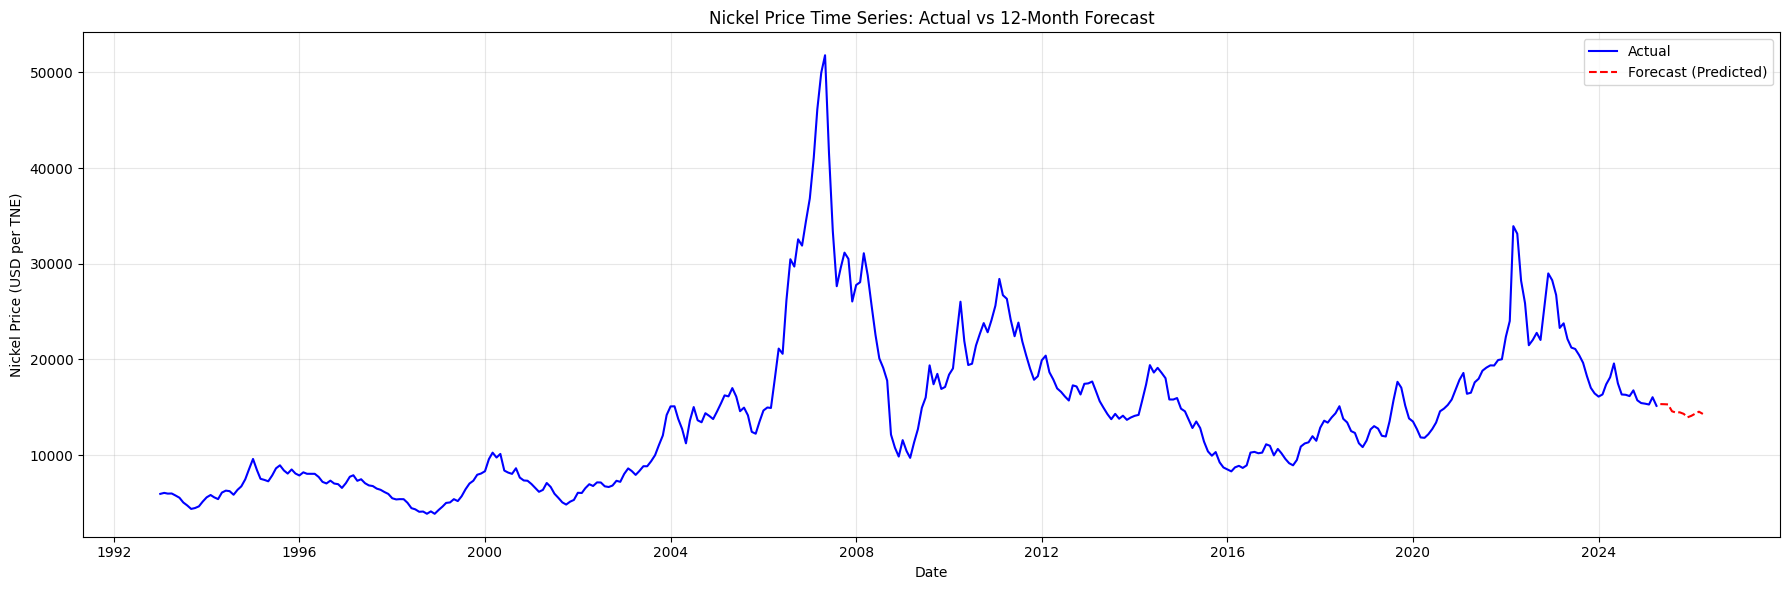

In [15]:
plt.figure(figsize=(18, 6))
# Plot actual data (all except last 12 rows)
plt.plot(final_data['DATE'][:-12], final_data['Predicted_Price'][:-12], label='Actual', color='blue')
# Plot predicted data (last 12 rows)
plt.plot(final_data['DATE'][-12:], final_data['Predicted_Price'][-12:], label='Forecast (Predicted)', color='red', linestyle='--')
plt.title('Nickel Price Time Series: Actual vs 12-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Nickel Price (USD per TNE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
final_data.to_excel(r"C:/Users/AS/Downloads/final_data.xlsx", index=False)